In [1]:
%%capture
!pip install scikit-lego shap

In [2]:
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklego.meta import ZeroInflatedRegressor
from sklearn.model_selection import train_test_split
import os

try:
    import util
except ImportError:
    if 'notebooks' in os.getcwd():
        os.chdir("..")
finally:
    import util

/home/jovyan/ForestLST/util/__init__.py:13: UserWarning: PyTorch not found! Module util.training will not be loaded.
  warnings.warn("PyTorch not found! Module util.training will not be loaded.")


In [3]:
# Prepare data - since we are working with tabular data here we convert
# to a dataframe.
ds = xr.open_dataset("data_working/westmort.nc")

# Calculate total basal area based on all the genus rasters
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

# Smoothing
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

# Average over time
ds["mortality_average"] = np.nancumsum(ds.mortality, axis=2) / np.cumsum(~np.isnan(ds.mortality), axis=2)

# Shift so we are doing proper out-year forecasting
ds["mort_nextyear"] = ds["mortality"].shift(time=-1)

# Also shift prcp on a few lags
ds["prcp1"] = ds["prcp"]
ds["prcp2"] = ds["prcp"].shift(time=1)
ds["prcp3"] = ds["prcp"].shift(time=2)
ds["prcp4"] = ds["prcp"].shift(time=3)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


In [4]:
df = ds[["elev", "forest_ba", "fire", "mort_nextyear", "prcp1", "prcp2", "prcp3", "prcp4", "vp", "vod"]].to_dataframe().reset_index().dropna()
df.head()

,time,y,x,elev,forest_ba,fire,mort_nextyear,prcp1,prcp2,prcp3,prcp4,vp,vod
1389566,2000,4682302.419,-1.343022e+07,931.0,33.0,0.0,0.0,1417.0,1290.0,1984.0,1561.0,1191.0,491.0
1389567,2000,4682302.419,-1.342622e+07,1050.0,37.0,0.0,0.0,1478.0,1373.0,2049.0,1624.0,1203.0,491.0
1389568,2000,4682302.419,-1.342222e+07,1137.0,49.0,0.0,0.0,1500.0,1415.0,2046.0,1683.0,1206.0,491.0
1389569,2000,4682302.419,-1.341822e+07,1256.0,74.0,0.0,0.0,1461.0,1396.0,2004.0,1679.0,1210.0,491.0
1389570,2000,4682302.419,-1.341422e+07,1310.0,71.0,0.0,0.0,1439.0,1385.0,1993.0,1666.0,1223.0,491.0


In [5]:
df.shape

(920041, 13)

How does the test/train split affect model interpretation via SHAP? We know that temporal CV is necessary to ensure good generalizability, but what about the SHAP curves?

First, define train, validation, and testing periods.

In [6]:
years = df.time.unique()

train_years = years[10:]
valid_years = years[:5]
test_years = years[5:10]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [2010 2011 2012 2013 2014 2015 2016 2017 2018]
Validation years: [2000 2001 2002 2003 2004]
Testing years: [2005 2006 2007 2008 2009]


Set the test set aside. Construct two train/test sets. One where the years are kept separate, and one where they are shuffled.

In [7]:
df_train = df[df.time.isin(train_years)]
df_valid = df[df.time.isin(valid_years)]
df_test  = df[df.time.isin(test_years)]

coords = ["time", "y", "x"]

# Hang onto corodinates in case we want to remake the predictions
# into an xarray dataset based on the pandas index.
coord_df = df[coords]

df_train = df_train.drop(columns=coords)
df_valid = df_valid.drop(columns=coords)
df_test  = df_test.drop(columns=coords)

# Mix the train/valid sets together. This is the case when we don't use
# temporal CV.
df_train_mix, df_valid_mix = train_test_split(
    pd.concat([df_train, df_valid]), 
    train_size=df_train.shape[0], test_size=df_valid.shape[0]
)

In [8]:
def split_xy(df, target):
    return (
        df.drop(columns=target).to_numpy(),
        df[target].to_numpy()
    )

def get_results(m, X, y):
    y_hat = m.predict(X)
    return {
        "mse": mean_squared_error(y, y_hat),
        "nrmse": np.sqrt(mean_squared_error(y, y_hat)) / np.mean(y),
        "r2": explained_variance_score(y, y_hat)
    }

In [9]:
# Training
target = "mort_nextyear"

m_random = RandomForestRegressor(
    oob_score=True,
    max_features="sqrt"
)

m_temporal_cv = RandomForestRegressor(
    oob_score=True,
    max_features="sqrt"
)

X_cv, y_cv = split_xy(df_train, target)
X_random, y_random = split_xy(df_train_mix, target)


m_random.fit(
    X_random, y_random
)

m_temporal_cv.fit(
    X_cv, y_cv
)

print("Temporal split")
print({
    "mse": mean_squared_error(y_cv, m_temporal_cv.oob_prediction_),
    "r2": explained_variance_score(y_cv, m_temporal_cv.oob_prediction_)
})

print("Random split")
print({
    "mse": mean_squared_error(y_random, m_random.oob_prediction_),
    "r2": explained_variance_score(y_random, m_random.oob_prediction_)
})

# This is artificially inflated because we aren't running
# on out of bag samples. Need to use the oob_prediction_
# property.
# train_result = get_results(m, X, y)
# print(train_result)

Temporal split
{'mse': 0.9971915279056552, 'r2': 0.40053935934757057}
Random split
{'mse': 1.0096111630467217, 'r2': 0.3577877110465484}


In [10]:
# Now collect validation stats. The random split might do better here because of
# information leakage.
X_valid_cv, y_valid_cv = split_xy(df_valid, target)
X_valid_random, y_valid_random = split_xy(df_valid_mix, target)

y_hat_cv = m_temporal_cv.predict(X_valid_cv)
y_hat_random = m_random.predict(X_valid_random)

print("Temporal split")
print({
    "mse": mean_squared_error(y_valid_cv, y_hat_cv),
    "r2": explained_variance_score(y_valid_cv, y_hat_cv)
})

print("Random split")
print({
    "mse": mean_squared_error(y_valid_random, y_hat_random),
    "r2": explained_variance_score(y_valid_random, y_hat_random)
})

Temporal split
{'mse': 1.5177701879320527, 'r2': -0.1210099768506443}
Random split
{'mse': 0.9842102169960977, 'r2': 0.3846005427761161}


In [11]:
# Finally, check on test stats. BOTH models do poorly,
# but only the temporal CV uncovers that in the validation step.
X_test, y_test = split_xy(df_test, target)

y_test_hat_cv = m_temporal_cv.predict(X_test)
y_test_hat_random = m_random.predict(X_test)

print("Temporal split")
print({
    "mse": mean_squared_error(y_test, y_test_hat_cv),
    "r2": explained_variance_score(y_test, y_test_hat_cv)
})

print("Random split")
print({
    "mse": mean_squared_error(y_test, y_test_hat_random),
    "r2": explained_variance_score(y_test, y_test_hat_random)
})

Temporal split
{'mse': 0.9784975468942628, 'r2': -0.1835464412471437}
Random split
{'mse': 0.914326881365576, 'r2': -0.1062936212767902}


In [12]:
# Now run SHAP on both models. Sample 1,000 samples from the test set
import shap

# Use kmeans to sample the background so we know we reproduce the distribution
# of the input data.
X_test_sample = shap.kmeans(X_test, 50).data

names = [x for x in df_test.columns if x != target]

te_cv = shap.KernelExplainer(lambda x: m_temporal_cv.predict(x), X_test_sample, feature_names=names)
te_random = shap.KernelExplainer(lambda x: m_random.predict(x), X_test_sample, feature_names=names)

In [13]:
shap_cv = te_cv(X_test_sample)
shap_random = te_random(X_test_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

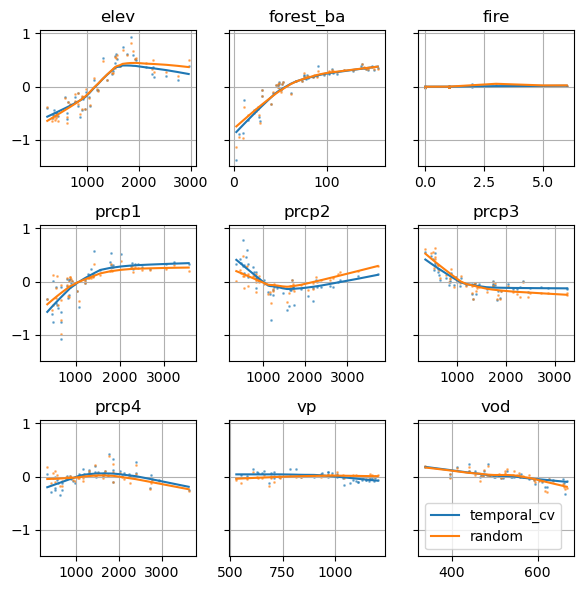

In [14]:
# Plot SHAP for both models on all features, with lowess smooth
import statsmodels.api as sm

fig, axes = plt.subplots(3, 3, sharey=True, sharex=False, figsize=(6, 6))

for (i, ax) in zip(range(len(names)), axes.flat):
    name = names[i]
    for (model, exp) in zip(("temporal_cv", "random"), (shap_cv, shap_random)):
        # Get lowess smooth
        smooth = sm.nonparametric.lowess(exog=exp.data[:, i], endog=exp.values[:, i])
        # Plot smooth and data
        ax.scatter(exp.data[:, i], exp.values[:, i], label=model, s=1, alpha=0.5)
        ax.plot(smooth[:, 0], smooth[:, 1], label=model)
    ax.grid()
    ax.set_title(name)

handles, labels = axes[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
fig.tight_layout()
plt.show()

In [15]:
# df.to_csv("data_working/westmort_tabular.csv")